In [ ]:
### Request NEXRAD Composite in netCDF form

In [1]:
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from siphon.catalog import TDSCatalog
import numpy as np
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from cmap_new import make_cmap
from functions import horiz_cbar

# Start and end times of data
end = datetime.utcnow()
start = end - timedelta(hours=1) # Query the last hour of data
print(end)

2019-06-09 15:50:53.281101


In [2]:
# Fetch the catalog of available products
nexrad = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/nexrad/composite/unidata/catalog.xml')
ncss = nexrad.datasets[0].subset()
print(ncss)

In [3]:
# Perform the query
query = ncss.query()
query.time_range(start,end).accept('netcdf4').variables('all')
data = ncss.get_data(query)

In [4]:
# Convert the netCDF4 dataset to xarray in order to parse metadata
dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
dat = dataset.metpy.parse_cf()

# Get the cartopy data projection
data_crs = dat['Base_reflectivity_surface_layer'].metpy.cartopy_crs
print(data_crs)

/home/meteo/kps5442/.conda/envs/mybase/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [5]:
# Get the x and y coordinates
x = dat['Base_reflectivity_surface_layer'].metpy.x
y = dat['Base_reflectivity_surface_layer'].metpy.y
print(x)

<xarray.DataArray 'x' (x: 4736)>
array([-2115958. , -2114942. , -2113925.5, ...,  2693886.8,  2694902.8,
        2695919.2], dtype=float32)
Coordinates:
  * x        (x) float32 -2115958.0 -2114942.0 ... 2694902.8 2695919.2
    crs      object Projection: lambert_conformal_conic
Attributes:
    standard_name:        projection_x_coordinate
    units:                meter
    _CoordinateAxisType:  GeoX
    _metpy_axis:          X


In [6]:
# Get base reflectivity for most recent time
ref = dat['Base_reflectivity_surface_layer'][-1,:,:]
print(ref)

<xarray.DataArray 'Base_reflectivity_surface_layer' (y: 3000, x: 4736)>
[14208000 values with dtype=float32]
Coordinates:
    reftime  datetime64[ns] ...
    time     datetime64[ns] 2019-06-09T15:40:00
  * y        (y) float32 -1678754.8 -1677738.5 ... 1367663.0 1368679.1
  * x        (x) float32 -2115958.0 -2114942.0 ... 2694902.8 2695919.2
    crs      object Projection: lambert_conformal_conic
Attributes:
    long_name:                      Base reflectivity @ Ground or water surfa...
    units:                          dB
    description:                    Base reflectivity
    grid_mapping:                   LambertConformal_Projection
    Grib_Variable_Id:               VAR_0-15-1_L1_layer
    Grib2_Parameter:                [ 0 15  1]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Radar
    Grib2_Parameter_Name:           Base reflectivity
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water s

In [7]:
# Get the valid time
time = dat['Base_reflectivity_surface_layer'].metpy.time
valid = datetime.strptime(str(time[-1].values)[0:16],'%Y-%m-%dT%H:%M')
print(datetime.strftime(valid, '%H:%M UTC %d %B %Y'))

15:40 UTC 09 June 2019


In [8]:
# Stuff for colormap generation
cmap_range = (10,70) #dBZ

values = [10,15,22,27,33,40,50,60,70]
print(values)
positions = [(x-10)/60 for x in values]
print(positions)

[10, 15, 22, 27, 33, 40, 50, 60, 70]
[0.0, 0.08333333333333333, 0.2, 0.2833333333333333, 0.38333333333333336, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]


In [9]:
colors = [[(75,85,125,0)], [(75,200,255,0.8)], [(15,185,20)], [(10,100,10)], [(5,80,5)],
         [(250,235,0)], [(250,80,0),(255,0,0)], [(100,0,0),(255,255,230)], [(255,0,200)]]
my_cmap = make_cmap(colors, positions)

In [10]:
from colormaps import ref_cmap
cmap, labels, cmap_range = ref_cmap()

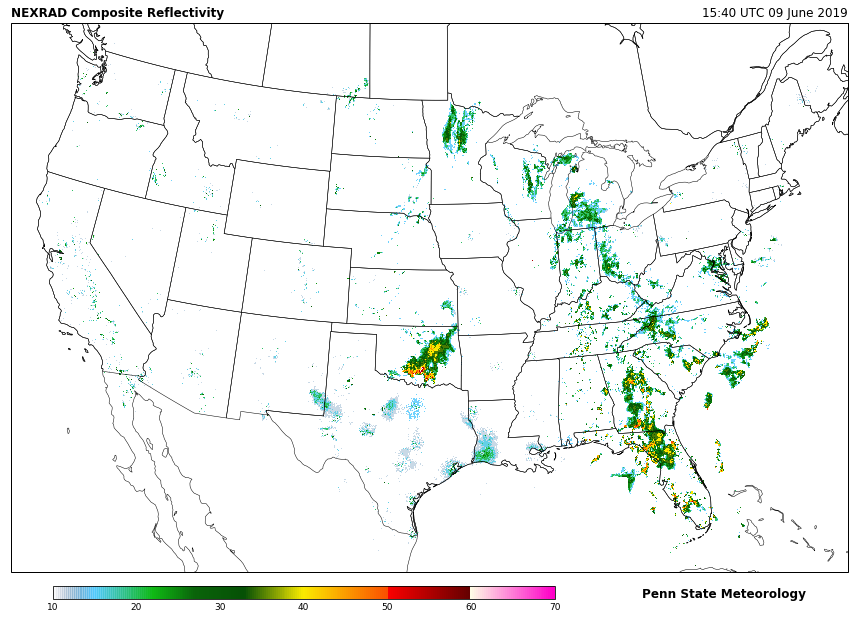

In [11]:
# Plot the data over the CONUS domain
fig = plt.figure(figsize=(15, 12))

proj = ccrs.LambertConformal()
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.set_extent([x.min(),x.max(),y.min(),y.max()], crs=data_crs)

plot = ax.imshow(ref, origin='lower',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=data_crs,
          interpolation='none',
          cmap=cmap, vmin=cmap_range[0], vmax=cmap_range[1])

ax.coastlines(resolution='50m', color='black', linewidth=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Add titles
plt.title('NEXRAD Composite Reflectivity', loc='left', fontweight='bold')
plt.title(datetime.strftime(valid, '%H:%M UTC %d %B %Y'), loc='right')

horiz_cbar(plot, ax, labels)

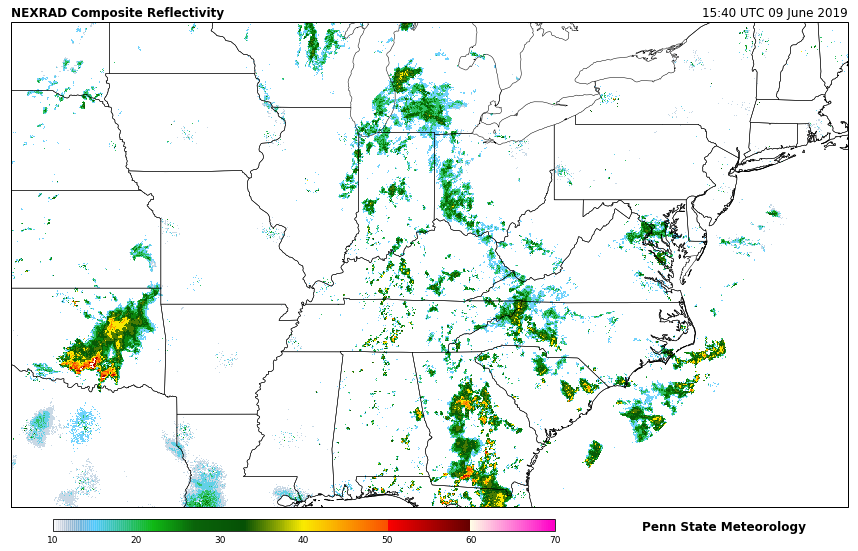

In [12]:
# Plot the data over a custom domain
fig = plt.figure(figsize=(15, 12))

proj = ccrs.Miller()
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.set_extent([-100, -70, 30, 45], crs=ccrs.PlateCarree())

plot = ax.imshow(ref, origin='lower',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=data_crs,
          interpolation='none',
          cmap=my_cmap, vmin=cmap_range[0], vmax=cmap_range[1])

ax.coastlines(resolution='10m', color='black', linewidth=0.5)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Add titles
plt.title('NEXRAD Composite Reflectivity', loc='left', fontweight='bold')
plt.title(datetime.strftime(valid, '%H:%M UTC %d %B %Y'), loc='right')

horiz_cbar(plot, ax, [10,20,30,40,50,60,70], tick_lab_size=9, cbar_width='60%',cbar_height='2.5%', left_offset=0.05, logo=True)

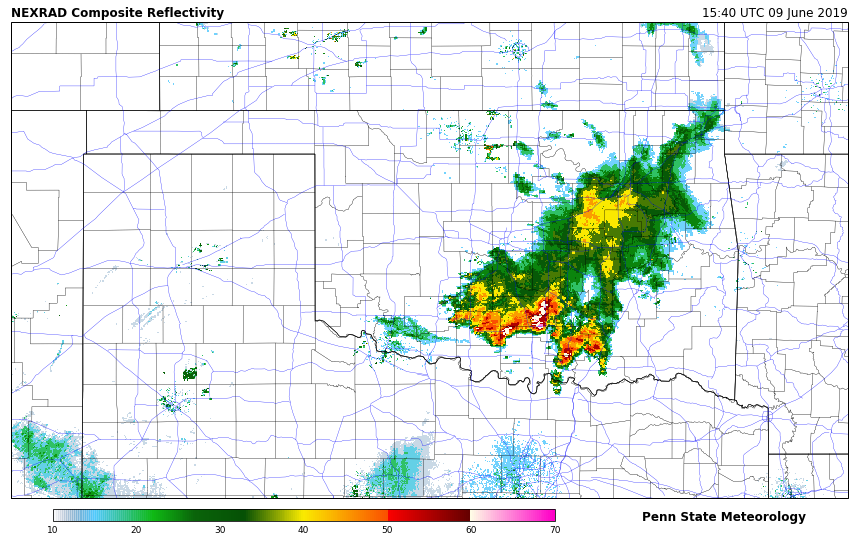

In [17]:
# Plot with counties on a state level
from metpy.plots import USCOUNTIES

fig = plt.figure(figsize=(15, 12))

proj = ccrs.Miller()
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.set_extent([-104, -93, 32.5, 38], crs=ccrs.PlateCarree())

plot = ax.imshow(ref, origin='lower',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=data_crs,
          interpolation='none',
          cmap=cmap, vmin=cmap_range[0], vmax=cmap_range[1])

ax.coastlines(resolution='10m', color='black', linewidth=0.5)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.2)

roads = cfeature.NaturalEarthFeature(
        category='cultural',
        name='roads',
        scale='10m',
        facecolor='none')
ax.add_feature(roads, edgecolor='blue', linewidth=0.3)

# Add titles
plt.title('NEXRAD Composite Reflectivity', loc='left', fontweight='bold')
plt.title(datetime.strftime(valid, '%H:%M UTC %d %B %Y'), loc='right')

horiz_cbar(plot, ax, labels)

## Load Radar Composite from Iowa State

In [55]:
# Load the data from Iowa State
from datetime import datetime, timedelta
import urllib.request as request
import re

image_gap = 10 #minutes - time between images

# Start and end times for range of images to generate
end_date = datetime.utcnow() # YYYY, MM, DD, HH, MM
start_date = datetime.utcnow() - timedelta(hours=1) # YYYY, MM, DD, HH, MM

# Get a list of file names for dates of interest, sort
numdays = int(round((end_date - start_date)/timedelta(days=1)))
date_list = [start_date + timedelta(days=x) for x in range(0, numdays+2)]
file_list=[]
for target_date in date_list:
    try:
        url = datetime.strftime(target_date, 'https://mesonet.agron.iastate.edu/archive/data/%Y/%m/%d/GIS/uscomp/')
        files = re.findall(r"""<\s*a\s*href=["'](n0q[^=]+.png)["']""", request.urlopen(url).read().decode("utf-8"))
        file_list = file_list + files
    except:
        None

# Make sure each file is between start and end time, filter
start_time = datetime.strftime(start_date, '%Y%m%d%H%M')
end_time = datetime.strftime(end_date, '%Y%m%d%H%M')
file_list = [file for file in file_list if file[-16:-4]>start_time and file[-16:-4]<end_time]
file_list = file_list[::int(image_gap/5.)]
print(file_list)


['n0q_201907072330.png', 'n0q_201907072340.png', 'n0q_201907072350.png', 'n0q_201907080000.png', 'n0q_201907080010.png', 'n0q_201907080020.png']


/home/meteo/kps5442/.conda/envs/mybase/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


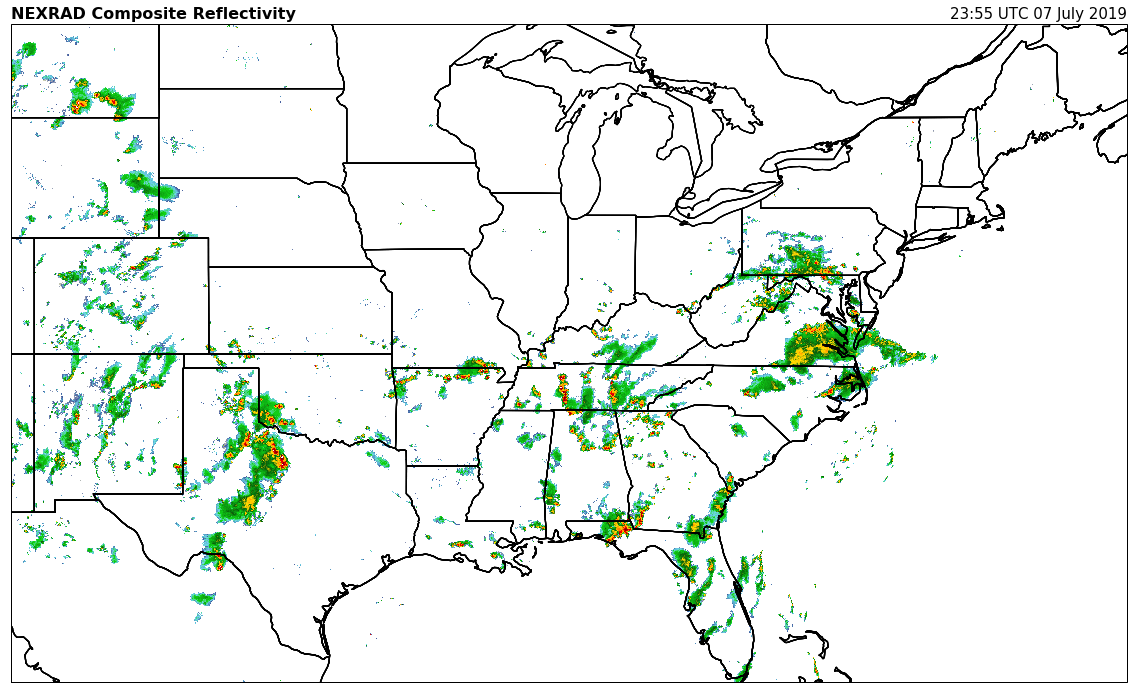

In [52]:
import imageio
import xarray
import numpy as np
from functions import mapper
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os

# Pre-defined 
extent = [-110,-65, 25, 48]
figsize = (20,16)

# Create a directory to save images
os.chdir('radar')
dir_name = 'uscompDownloaded_'+datetime.strftime(datetime.utcnow(), '%Y%m%d%H%M')
os.system('mkdir '+dir_name)
os.chdir(dir_name)

for file in file_list:
    valid_time = datetime.strptime(file[-16:-4],'%Y%m%d%H%M')
    fn = datetime.strftime(valid_time,
                           'https://mesonet.agron.iastate.edu/archive/data/%Y/%m/%d/GIS/uscomp/') + file
    fwld = datetime.strftime(valid_time,
                           'https://mesonet.agron.iastate.edu/archive/data/%Y/%m/%d/GIS/uscomp/') + file[0:-3] + 'wld'
    img = imageio.imread(fn)
    wld = np.loadtxt(fwld)
    
    # Image processing - turn black backround to white
    image = img[..., :3]
    image[np.where((image==[0,0,0]).all(axis=2))] = [255,255,255]

    # Get lat/lon for plotting
    nxy = img.shape[:2]
    ny, nx = nxy
    lat = np.linspace(wld[5] + ny * wld[3], wld[5], ny)
    lon = np.linspace(wld[4], wld[4] + nx * wld[0], nx)

    ax = mapper(extent,figsize,proj='Miller')

    plot = ax.imshow(image, origin='upper',
              extent=(lon.min(), lon.max(), lat.min(), lat.max()),
              transform=ccrs.PlateCarree(),
              interpolation='none',)

    plt.title('NEXRAD Composite Reflectivity', loc='left', fontweight='bold', fontsize=16)
    plt.title(datetime.strftime(valid_time, '%H:%M UTC %d %B %Y'), loc='right', fontsize=15)
    
    #Save image
    plt.savefig(file,bbox_inches='tight')

## Plot individual NEXRAD sites


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


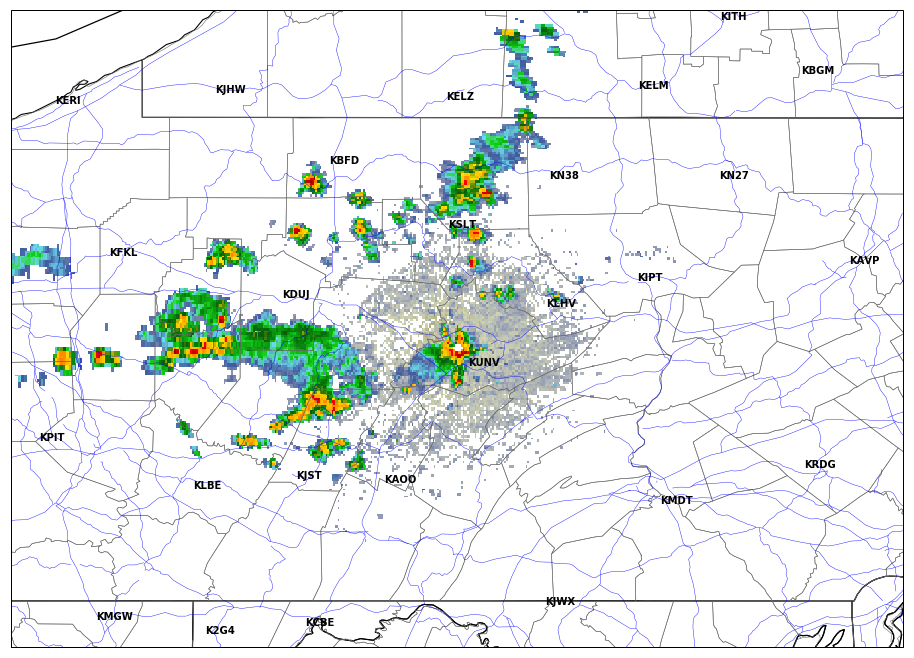

In [6]:
# Load some test data
%load_ext autoreload
%autoreload

from datetime import datetime, timedelta
import imageio
import xarray
import numpy as np

fn = 'https://mesonet.agron.iastate.edu/archive/data/2019/06/29/GIS/ridge/CCX/N0Q/CCX_N0Q_201906291601.png'
fwld = 'https://mesonet.agron.iastate.edu/archive/data/2019/06/29/GIS/ridge/CCX/N0Q/CCX_N0Q_201906291601.wld'

img = imageio.imread(fn)
wld = np.loadtxt(fwld)

# Image processing - turn black backround to white
image = img[..., :3]
image[np.where((image==[0,0,0]).all(axis=2))] = [255,255,255]

# Get lat/lon for plotting
nxy = img.shape[:2]
ny, nx = nxy
lat = np.linspace(wld[5] + ny * wld[3], wld[5], ny)
lon = np.linspace(wld[4], wld[4] + nx * wld[0], nx)

from functions import mapper
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

extent = [-80.5,-75.5,39.5,42.5]
figsize = (16,16)

kw_gis = {'counties':True, 'roads':True, 'resolution':'10m'}

ax = mapper(extent,figsize,proj='Miller', **kw_gis)

plot = ax.imshow(image, origin='upper',
          extent=(lon.min(), lon.max(), lat.min(), lat.max()),
          transform=ccrs.PlateCarree(),
          interpolation='none')

from functions import asos_list
stns = asos_list(extent, point_density=0.5)
for stn in stns:
    ax.text(stn['lon'], stn['lat'], stn['id'], fontweight='bold',
            horizontalalignment='center', verticalalignment='center',
            clip_on=True, transform=ccrs.PlateCarree())

In [1]:
%load_ext autoreload
%autoreload
from radar import iowa_state_composite
from datetime import datetime,timedelta

# Initialize an object for the project
x = iowa_state_composite()
x.set_start(datetime(2019,7,7,17,0,0)) #17z July 7
x.set_end(datetime(2019,7,7,19,0,0)) #19z July 7
x.set_interval(30) # 30 mins between images
x.set_extent([-90, -70, 35, 45]) #Mid-Atlantic Region
x.set_gis_params({'counties':True, 'asos_sites':True, 'asos_density':0.8})
x.plot_composites()